# <ins>Predicting Poetic Movements</ins>

# Natural Language Processing and Data Exploration

- In this notebook, I engineer features based on poetic form and structure, perform natural language processing techniques, and explore my data.
- I also create charts and word clouds based on this exploration.

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Answering some initial questions](#Step-1:-Answering-some-initial-questions)
5. [Step 2: Preparing the data](#Step-2:-Preparing-the-data)

    - [Create movements](#Create-movements)
    
    
6. [Step 3: Feature engineering and exploratory data analysis](#Step-3:-Feature-engineering-and-exploratory-data-analysis)

    - [Number of lines](#Number-of-lines)
        - [Chart](#Number-of-lines----Boxplot)
    - [Number of words](#Number-of-words)
        - [Chart](#Number-of-words----Boxplot)
    - [Average line length](#Average-line-length)
        - [Chart](#Average-line-length----Boxplot)
    - [Sentiment, polarity](#Sentiment,-polarity)
        - [Chart 1](#Polarity-score----Boxplot) | [Chart 2](#Polarity----Stacked-bar-chart)
    - [Sentiment, subjectivity](#Sentiment,-subjectivity)
        - [Chart](#Subjectivity-score----Boxplot)
    - [Number of end rhymes](#Number-of-end-rhymes)
        - [Chart](#Number-of-end-rhymes----Boxplot)
    - [Ratio of end rhymes](#Ratio-of-end-rhymes)
        - [Chart](#Ratio-of-end-rhymes----Boxplot)
    - [End rhymes, categorical](#End-rhymes,-categorical)
        - [Chart](#End-rhymes----Stacked-bar-chart)
    - [Syllables per word](#Syllables-per-word)
        - [Chart](#Syllables-per-word----Boxplot)
    - [Lexical richness](#Lexical-richness)
        - [Chart](#Lexical-richness----Boxplot)
    
    
7. [Step 4: Natural language processing](#Step-4:-Natural-language-processing)

    - [Total word counts and vocabulary](#Total-word-counts-and-vocabulary)
    - [Most frequent words](#Most-frequent-words)
        - [Chart 1](#Most-frequent-words-overall) | [Chart 2](#Most-frequent-words-by-genre) | [Chart3](#Word-cloud-overall) | [Chart 4](#Word-clouds-by-genre)
    

8. [Preliminary conclusions](#Preliminary-conclusions)
9. [Save/Load DataFrame](#💾-Save/Load-DataFrame)
10. [Next notebook: Modeling](#Next-notebook:-Modeling)

## Introduction

[[go back to the top](#Predicting-Poetic-Movements)]

After [scraping](01_webscraping.ipynb) PoetryFoundation.org for genre-labeled poems and [cleaning](02_data_cleaning.ipynb), I will use natural language processing (NLP) techniques to analyze poetic structure across poetic genres and movements. 

Through text processing, exploratory data analysis, and feature engineering, I will look for insights into how poetic structure, word usage, lexical richness, and sentiment relate to the genre of a poem.

I will then create predictive models that classify poems into one of four umbrella movements: *Avant-Garde*, *Metropolitan*, *Modern*, or *Pre-1900*. This will help provide further insight and confirm my findings during EDA. *(To skip to the modeling notebook, click [here](04_modeling.ipynb))*.

The ultimate goal is to create a recommendation system that compares poem similarities and recommends individual poems to users. *(To skip to the recommendation system notebook, click [here](05_recommendation_system.ipynb))*.

## The problem domain

[[go back to the top](#Predicting-Poetic-Movements)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and searches that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Predicting-Poetic-Movements)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **textblob**: A supplementary package to enhance the nltk package.
- **vaderSentiment**: A sentiment analysis tool based on human-compiled data.
- **wordcloud**: A library focused on plotting word frequencies.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that I built for this project.

Required within the functions file, are:
- **itertools**: An package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.

Run the cell below to import all of the necessary packages.

In [1]:
# custom functions for this project
from functions import *

# dataframe packages
import pandas as pd
import numpy as np

# graphing packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# statistics packages
import scipy.stats as stats

# text processing
from nltk.corpus import stopwords
from nltk.probability import FreqDist 
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# miscellany
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

# Step 1: Answering some initial questions

[[go back to the top](#Predicting-Poetic-Movements)]

**Where does the data come from?**

> The data is comprised of 4,307 poems from [PoetryFoundation.org](https://www.poetryfoundation.org/), after dropping some older genres of poetry (*Middle English*, *Renaissance*, and *Augustan*), as well as some lesser-known, allegedly white supremacist genres (*Georgian* and *Fugitive*).

> The data came in both text format and as scanned images, from which I was able to capture the text using PyTesseract.

> I scraped the data myself, using custom functions that can be found in this [file](functions_webscraping.py). Refer to the webscraping [notebook](01_webscraping.ipynb) for a closer look at the scraping (and rescraping) process. The original count of scraped poems was 5,197, though this did include some duplicate scrapes.

> Refer to the data cleaning [notebook](02_data_cleaning.ipynb) for a detailed guide on the cleaning process, which included dropping duplicates and more rescraping.

**What do the variables mean in actual language?**

> The poem itself is the main variable--I scraped the poem as both a list of lines, as well as an endline-joined (\n) string. Also scraped were the poem's URL, for reference if necessary, the name of the poet, title of the poem, and the target variable, genre. 

> Other variables I look at within this notebook are ones that I engineered. They are listed below:
> - <ins>Number of lines</ins>
    - The standard measure of the length of a poem. Prose poems, however, do complicate this as they are often only one line.
    <br/><br/>
> - <ins>Average number of words per line</ins>
    - A measure of the length of each line within a poem, which can be fairly telling of time period, as more contemporary poems tend to have fewer words in a line. That said, there is often a back and forth across time as art movements continously reject past movements.
    <br/><br/>
> - <ins>Average number of syllables per word</ins>
    - A proxy for complexity of language. More complex language will use words with more syllables on average than simpler language.
    <br/><br/>
> - <ins>Number and usage of end rhymes</ins>
    - End rhymes occur when a word at the end of a line rhymes with another word at the end of a line. During EDA, I look at this as both a continuous and categorical variable.
    <br/><br/>
> - <ins>Sentiment (polarity and subjectivity)</ins>
    - Whether a poem uses positive, negative, or neutral language (polarity) and whether a poem uses more opinion-based language (subjective) or fact-based language (objective).
    <br/><br/>
> - <ins>Lexical richness</ins>
    - A measure of the number of unique words within a poem. A lower value indicates a more repetitious poem, whereas a value of 1.0 would indicate that each word is used only once.

**What is the target variable?**

> The target variable is the genre of the poem, which was provided by PoetryFoundation.org. In order to limit the number of classes for my classification models, I created umbrella movements using my domain knowledge of poetry alongside some research. The list of genres (and their umbrella movement) is below:
> - Beat (Metropolitan)
> - Black Arts Movement (Metropolitan)
> - Black Mountain (Avant-Garde)
> - Confessional (Metropolitan)
> - Harlem Renaissance (Metropolitan)
> - Imagist (Avant-Garde)
> - Language Poetry (Avant-Garde)
> - Modern (Modern)
> - New York School (Metropolitan)
> - New York School, 2nd Generation (Metropolitan)
> - Objectivist (Avant-Garde)
> - Romantic (Pre-1900)
> - Victorian (Pre-1900)

> It's worth noting that the umbrella movements are not perfect but are a decent direction to go with. Modern is a very overrepresented genre and is its own category. Pre-1900 poetries are self-explanatory. There is definitely some overlap between Modern, Metropolitan, and Avant-Garde poetries, but these are arguably correct delineations.
    
**What is the range, scale, or distribution of each variable?**

> These are detailed within each section of [Step 3](#Step-3:-Feature-engineering-and-exploratory-data-analysis).
    
**What elements of the data will or will not address the business question?**

> Poem URLS were only used during the rescraping process. Also, the name of the poet will not (and cannot, scientifically) be used to predict the poetic movement of a poem. Though I do not use it in this project, the name of the poet could be a great variable to look into during EDA. 

> The main variables, as with most NLP projects, will be the individual word vectors, i.e. the language used in each poem.
    
**Are there any issues related to data permissions, copyright, ethical issues, confidential information, etc.?**

> Using this data is most assuredly not allowed under their [terms of service](https://www.poetryfoundation.org/foundation/terms-of-service). While there may be data permissions and copyright issues here, I do not think there is anything ethically wrong with the project, as I am not publishing any of the poetry scraped from the site. In fact the poetry generator I create using this project links to their website and would only increase the traffic their site receives. Furthermore, I am definitely not making any money off of the project, and I believe the project is of scientific value.
    
**Are there any interesting aspects or anomalies in the data such as outliers or missing data?**

> One notable aspect of the data is that the OCR (optical character recognition) or image-to-text tool, PyTesseract, is imperfect so some of the individual words and lines may have been scraped incorrectly. I also had some difficulty  consistently scraping multiple page poems (since PyTesseract sometimes does not grab page numbers), again due to this imperfection. As a result, some poems are truncated versions of themselves, though I do believe a lot of this was corrected during my arduous rescraping process.

> After the data cleaning process in the [previous notebook](02_data_cleaning.ipynb), there shouldn't be any missing data.
    
**What additional data would be really helpful to your analysis?**

> An accurate year of publication (or better yet, of writing) would be really helpful. I had originally scraped the year from the site, but it was inconsistent and often reflected the year it was published in the magazine, rather than the actual year of the poem. Ideally, with this information, I could spot trends across time regarding many of my engineered features, as well as the language itself.

> It may be worth, in the future, considering analyzing the role of gender among the variables. Potentially interesting, even if they end up being fairly equal.

**Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?**

> This will be an NLP, exploration, feature engineering, classification, and recommendation system project. To look at the classification portion of the project, refer to the [modeling notebook](04_modeling.ipynb). To look at the classification portion of the project, refer to the [recommendation system notebook](05_recommendation_system.ipynb). 

**Did you define the metric for success before beginning?**

> There is a small amount of class imbalance after creating the umbrella movements, so I will still use F1 score over accuracy, as the F1 score is the most complete measure of false predictions and doesn't overemphasize models that overpredict one class.

# Step 2: Preparing the data

[[go back to the top](#Predicting-Poetic-Movements)]

- Import the cleaned data.
- Take a look.
- Create umbrella movements.

#### 💾 Load DataFrame

In [2]:
with gzip.open('data/poems_df_clean_trim.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
df.shape

(4307, 6)

In [3]:
df.head()

poet  \
0  Allen Ginsberg   
1  Allen Ginsberg   
2  Allen Ginsberg   
3  Allen Ginsberg   
4  Allen Ginsberg   

                                                                   poem_url  \
0  https://www.poetryfoundation.org/poems/47660/a-supermarket-in-california   
1        https://www.poetryfoundation.org/poems/49305/america-56d22b41f119f   
2             https://www.poetryfoundation.org/poems/54163/footnote-to-howl   
3       https://www.poetryfoundation.org/poems/49311/homework-56d22b44cb0bd   
4                         https://www.poetryfoundation.org/poems/49303/howl   

                         title  \
0  A Supermarket in California   
1                      America   
2             Footnote to Howl   
3                     Homework   
4                         Howl   

                                                                                                                                              poem_lines  \
0  [What thoughts I have of you tonight, Walt Whitman, for I walked down the sidestreets under the trees with a headache self-conscious looking at th...   
1  [America I’ve given you all and now I’m nothing., America two dollars and twentyseven cents January 17, 1956., I can’t stand my own mind., America...   
2  [Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy!, The world is holy! The soul is holy! The skin is holy!...   
3  [If I were doing my Laundry I’d wash my dirty Iran, I’d throw in my United States, and pour on the Ivory Soap, scrub up Africa, put all the birds ...   
4  [I, I saw the best minds of my generation destroyed by madness, starving hysterical naked,, dragging themselves through the negro streets at dawn ...   

                                                                                                                                             poem_string  \
0  What thoughts I have of you tonight, Walt Whitman, for I walked down the sidestreets under the trees with a headache self-conscious looking at the...   
1  America I’ve given you all and now I’m nothing.\nAmerica two dollars and twentyseven cents January 17, 1956.\nI can’t stand my own mind.\nAmerica ...   
2  Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy! Holy!\nThe world is holy! The soul is holy! The skin is holy! ...   
3  If I were doing my Laundry I’d wash my dirty Iran\nI’d throw in my United States, and pour on the Ivory Soap, scrub up Africa, put all the birds a...   
4  I\nI saw the best minds of my generation destroyed by madness, starving hysterical naked,\ndragging themselves through the negro streets at dawn l...   

  genre  
0  beat  
1  beat  
2  beat  
3  beat  
4  beat

In [4]:
df.genre.value_counts()

modern                            1244
victorian                          642
romantic                           395
imagist                            350
new_york_school                    259
black_mountain                     256
language_poetry                    194
new_york_school_2nd_generation     188
confessional                       172
black_arts_movement                159
objectivist                        155
harlem_renaissance                 147
beat                               146
Name: genre, dtype: int64

### Create movements

[[go back to the top](#Predicting-Poetic-Movements)]

- To aid in prediction modeling, I'll separate genres into four overarching movements, based on personal domain knowledge of poetry as well as my research.

In [5]:
# sort genres into movements
conditions = [
    df.genre == 'victorian', df.genre == 'romantic',
    df.genre == 'new_york_school', df.genre == 'new_york_school_2nd_generation', df.genre == 'confessional',
        df.genre == 'beat', df.genre == 'harlem_renaissance', df.genre == 'black_arts_movement',
    df.genre == 'imagist', df.genre == 'black_mountain', df.genre == 'language_poetry', df.genre == 'objectivist'
]

# name movements, prepare 'other' to be dropped
choices = [
    'pre_1900', 'pre_1900',
    'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan',
    'avant_garde', 'avant_garde', 'avant_garde', 'avant_garde'
]

# convert data, leaving 'modern' untouched
df['movement'] = np.select(conditions, choices, df.genre)

- Check if classes are balanced or not.

In [6]:
# number of poems per movement
df.movement.value_counts()

modern          1244
metropolitan    1071
pre_1900        1037
avant_garde      955
Name: movement, dtype: int64

In [7]:
# percentage of total poems by movement
df.movement.value_counts(normalize=True)

modern          0.288832
metropolitan    0.248665
pre_1900        0.240771
avant_garde     0.221732
Name: movement, dtype: float64

In [8]:
# cumulative percentage of total poems by genre
df.movement.value_counts(normalize=True).cumsum()

modern          0.288832
metropolitan    0.537497
pre_1900        0.778268
avant_garde     1.000000
Name: movement, dtype: float64

In [9]:
# number of unique poets per genre
{movement:len(poets) for movement,poets in df.groupby('movement').poet.unique().items()}

{'avant_garde': 36, 'metropolitan': 80, 'modern': 52, 'pre_1900': 104}

# Step 3: Feature engineering and exploratory data analysis

[[go back to the top](#Predicting-Poetic-Movements)]

- Engineer numerical features based on aspects of a poem, including but not limited to line count, line length, usage of end rhymes, and lexical richness.
- Explore these features as a whole and across each movement.
- Create visualizations to better understand the differences and similarities between genres.

### Number of lines

[[go back to the top](#Predicting-Poetic-Movements)]

- The number of lines in a poem is the best measure for its length. I'd like to explore if any genres tend to have longer or shorter poems than the rest.
- First, clean up the lines by removing any empty lines that made it through the scraping process, as well as any Roman numerals or section numbers that are present in multi-part poems.
- Then count the remaining lines.

In [10]:
# see what the lines look like before cleaning
df.loc[40,'poem_lines'][:10]

['1',
 'I am a great American',
 'I am almost nationalistic about it!',
 'I love America like a madness!',
 'But I am afraid to return to America',
 'I’m even afraid to go into the American Express—',
 '2',
 'They are frankensteining Christ in America',
 'in their Sunday campaigns',
 'They are putting the fear of Christ in America']

In [11]:
# create column using custom function
df['clean_lines'] = df[['poem_lines', 'poet']].apply(lambda x: line_cleaner(x.poem_lines, x.poet), axis=1)

# check that it worked
df.loc[40, 'clean_lines'][:10]

['I am a great American',
 'I am almost nationalistic about it!',
 'I love America like a madness!',
 'But I am afraid to return to America',
 'I’m even afraid to go into the American Express—',
 'They are frankensteining Christ in America',
 'in their Sunday campaigns',
 'They are putting the fear of Christ in America',
 'under their tents in their Sunday campaigns',
 'They are driving old ladies mad with Christ in America']

In [12]:
# example 4-line poem
df.loc[142,'clean_lines']

['When you take your pill',
 'it’s like a mine disaster.',
 'I think of all the people',
 'lost inside of you.']

In [13]:
# create number of lines column
df['num_lines'] = df.clean_lines.apply(lambda x: len(x))

# check that it worked
df.loc[142,'num_lines']

4

In [14]:
# descriptive statistics for number of lines as a whole
df.num_lines.describe()

count    4307.000000
mean       40.269561
std        63.118049
min         1.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       892.000000
Name: num_lines, dtype: float64

In [15]:
# number of lines stats by genre
df.groupby('movement').num_lines.describe().T

movement  avant_garde  metropolitan       modern     pre_1900
count      955.000000   1071.000000  1244.000000  1037.000000
mean        35.579058     38.039216    33.272508    55.286403
std         45.155320     49.962718    46.336440    96.003670
min          1.000000      1.000000     1.000000     4.000000
25%         13.500000     16.000000    12.000000    14.000000
50%         23.000000     24.000000    19.000000    24.000000
75%         37.000000     40.000000    35.000000    51.000000
max        476.000000    617.000000   584.000000   892.000000

- Pre-1900 poetry definitely skews longer, although the median is roughly equal to Avant-Garde and Metropolitan.
- Modern poetry has a similar mean to Avant-Garde and Metropolitan, but a considerably lower median value.
- I'll perform a one-way ANOVA test.

#### Statistical analysis

In [16]:
# one-way ANOVA
stats.f_oneway(
    df['num_lines'][df['movement'] == 'avant_garde'],
    df['num_lines'][df['movement'] == 'metropolitan'], 
    df['num_lines'][df['movement'] == 'modern'],
    df['num_lines'][df['movement'] == 'pre_1900']
)

F_onewayResult(statistic=27.35929215444875, pvalue=1.6035725425838497e-17)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [17]:
# list of series on which to perform two-sided t-tests
num_lines_list = [
    df['num_lines'][df['movement'] == 'avant_garde'],
    df['num_lines'][df['movement'] == 'metropolitan'], 
    df['num_lines'][df['movement'] == 'modern'],
    df['num_lines'][df['movement'] == 'pre_1900']
]

In [18]:
# test each combination
two_way_tests(num_lines_list)

{(0,
  1): Ttest_indResult(statistic=-1.157448479979114, pvalue=0.24722574893666707),
 (0,
  2): Ttest_indResult(statistic=1.1698703858469264, pvalue=0.2421800263740353),
 (0,
  3): Ttest_indResult(statistic=-5.781903763034263, pvalue=8.556254942543303e-09),
 (1,
  2): Ttest_indResult(statistic=2.3799764321851318, pvalue=0.017394354707656563),
 (1,
  3): Ttest_indResult(statistic=-5.197197646171924, pvalue=2.2184576609377236e-07),
 (2,
  3): Ttest_indResult(statistic=-7.150200312370817, pvalue=1.1621015819312737e-12)}

- Most values are significant, except for those between Avant-Garde and Metropolitan and Avant-Garde and Modern.

### Number of lines -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

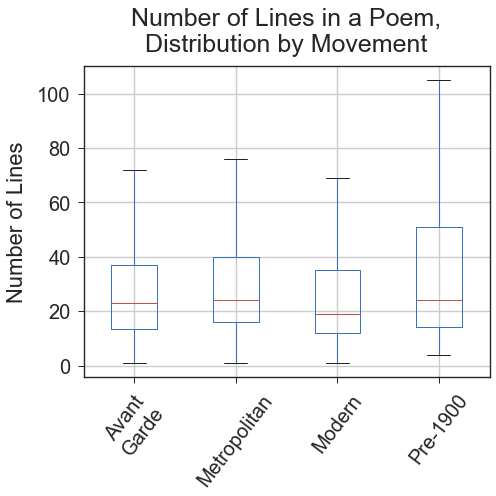

In [19]:
# plot the graph
df.boxplot('num_lines', 'movement', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Number of Lines in a Poem,\nDistribution by Movement', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of Lines', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/num_lines_boxplot.png', bbox_inches='tight', transparent=True)

plt.show()

- The first three movements look fairly similar (though again, Modern's median value is noticeably lower than the rest), but Pre-1900 poetry tends to be far longer than the rest.
- Its minimum and maximum values are considerably greater than the rest, and the distribution skews toward longer poems, even if the median is fairly similar to Avant-Garde and Metropolitan.

### Number of words

[[go back to the top](#Predicting-Poetic-Movements)]

- I'd like to see if the number of words holds any valuable information.
- Also, it will be necessary to calculate for many other features.
- Since some untitled poems use the first line of the poem as the title, and since I'll be using titles in my prediction model, I'll add the title to the poem now.
    - Some titles, however, are simply "Untitled", which I do not want to include.

In [20]:
# create column using custom function
df['lines_titled'] = df[['title', 'clean_lines']].apply(lambda x: titler(x.title, x.clean_lines), axis=1)

# check an example
df.loc[0, 'lines_titled']

['A Supermarket in California',
 'What thoughts I have of you tonight, Walt Whitman, for I walked down the sidestreets under the trees with a headache self-conscious looking at the full moon.',
 'In my hungry fatigue, and shopping for images, I went into the neon fruit supermarket, dreaming of your enumerations!',
 'What peaches and what penumbras! Whole families shopping at night! Aisles full of husbands! Wives in the avocados, babies in the tomatoes!—and you, Garcia Lorca, what were you doing down by the watermelons?',
 'I saw you, Walt Whitman, childless, lonely old grubber, poking among the meats in the refrigerator and eyeing the grocery boys.',
 'I heard you asking questions of each: Who killed the pork chops? What price bananas? Are you my Angel?',
 'I wandered in and out of the brilliant stacks of cans following you, and followed in my imagination by the store detective.',
 'We strode down the open corridors together in our solitary fancy tasting artichokes, possessing every fr

In [21]:
# manually fix one known special case
df.loc[2973, 'lines_titled'].pop(0)
df.loc[2973, 'lines_titled']

['pagne', 'cham.']

In [22]:
# create column using custom word counting function
df['num_words'] = df.lines_titled.apply(word_counter)

In [23]:
# number of words stats as a whole
df.num_words.describe()

count    4307.000000
mean      270.658463
std       470.618765
min         1.000000
25%        88.000000
50%       137.000000
75%       262.000000
max      7408.000000
Name: num_words, dtype: float64

In [24]:
# number of words stats by genre
df.groupby('movement').num_words.describe().T

movement  avant_garde  metropolitan       modern     pre_1900
count      955.000000   1071.000000  1244.000000  1037.000000
mean       200.342408    265.937442   224.454180   395.717454
std        274.190306    430.739183   333.644687   709.468952
min          6.000000      1.000000     9.000000    22.000000
25%         62.000000    103.000000    78.000000   111.000000
50%        110.000000    158.000000   124.000000   166.000000
75%        223.000000    268.000000   229.000000   353.000000
max       3041.000000   6998.000000  3894.000000  7408.000000

#### Statistical analysis

In [25]:
# one-way ANOVA
stats.f_oneway(
    df['num_words'][df['movement'] == 'avant_garde'],
    df['num_words'][df['movement'] == 'metropolitan'], 
    df['num_words'][df['movement'] == 'modern'],
    df['num_words'][df['movement'] == 'pre_1900']
)

F_onewayResult(statistic=36.42559702212827, pvalue=3.068318119246156e-23)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [26]:
# list of series on which to perform two-sided t-tests
num_words_list = [
    df['num_words'][df['movement'] == 'avant_garde'],
    df['num_words'][df['movement'] == 'metropolitan'], 
    df['num_words'][df['movement'] == 'modern'],
    df['num_words'][df['movement'] == 'pre_1900']
]

In [27]:
# test each combination
two_way_tests(num_words_list)

{(0,
  1): Ttest_indResult(statistic=-4.03341980974774, pvalue=5.70108857292468e-05),
 (0,
  2): Ttest_indResult(statistic=-1.8123388900153408, pvalue=0.07007030187686007),
 (0,
  3): Ttest_indResult(statistic=-7.978947339528002, pvalue=2.4681039183982638e-15),
 (1,
  2): Ttest_indResult(statistic=2.607618971375959, pvalue=0.009176062360908111),
 (1,
  3): Ttest_indResult(statistic=-5.0947448798676165, pvalue=3.8032961762316585e-07),
 (2,
  3): Ttest_indResult(statistic=-7.569293780909457, pvalue=5.413712598836536e-14)}

- All but one of the tests produced statistically significant results. 
- A boxplot may paint a better picture.

### Number of words -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

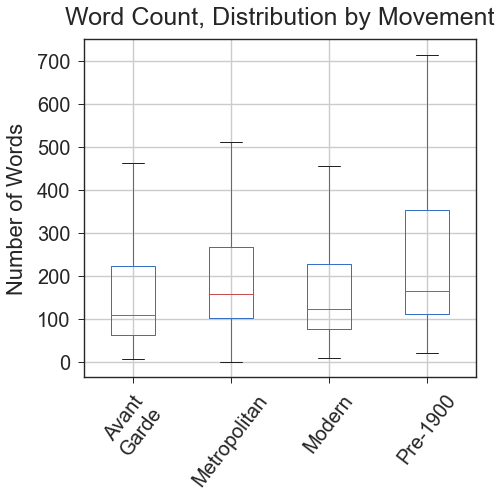

In [28]:
# plot the graph
df.boxplot('num_words', 'movement', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Word Count, Distribution by Movement', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of Words', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/num_words_boxplot.png', bbox_inches='tight', transparent=True)

plt.show()

- The median values here appear to be more variable than with the number of lines.
- Avant-Garde appears to be the least wordy, and again Pre-1900 poetry is the most verbose.
- I'd like to see the relationship between the number of lines and the number of words.

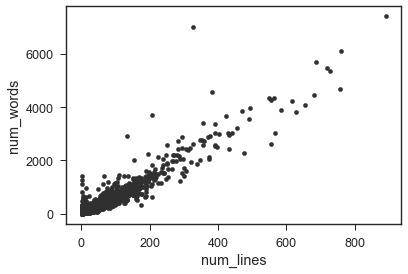

In [29]:
df.plot.scatter('num_lines', 'num_words');

In [30]:
# check correlation
df.num_lines.corr(df.num_words)

0.9485169419375078

- Indeed, they are very correlated, so I'll drop one of these columns later on.

### Average line length

[[go back to the top](#Predicting-Poetic-Movements)]

- I can use both of the previously engineered columns to create a measure of the average number of words per line in a poem. My impression is that lines have become shorter over the passage of time, so I'm eager to see if the data bears that out.
- After creating the variable, I'll look at it across all data and by each movement.

In [31]:
# create column of average number of words per line
df['avg_len_line'] = df.num_words / df.num_lines

In [32]:
# average length of line stats as a whole
df.avg_len_line.describe()

count    4307.000000
mean        8.449181
std        37.933747
min         1.000000
25%         5.260870
50%         6.527778
75%         7.714286
max      1403.000000
Name: avg_len_line, dtype: float64

In [33]:
# average length of line stats by genre
df.groupby('movement').avg_len_line.describe().T

movement  avant_garde  metropolitan       modern     pre_1900
count      955.000000   1071.000000  1244.000000  1037.000000
mean         9.330865      8.261727     8.946835     7.233823
std         56.609397     27.307849    43.345610     1.716085
min          1.230769      1.000000     1.446809     3.375000
25%          3.866601      5.268750     5.693614     6.111111
50%          5.122302      6.579710     6.787594     7.010753
75%          6.609351      7.916667     7.750000     8.062500
max       1258.000000    811.000000  1403.000000    23.000000

#### Statistical analysis

In [34]:
# one-way ANOVA
stats.f_oneway(
    df['avg_len_line'][df['movement'] == 'avant_garde'],
    df['avg_len_line'][df['movement'] == 'metropolitan'], 
    df['avg_len_line'][df['movement'] == 'modern'],
    df['avg_len_line'][df['movement'] == 'pre_1900']
)

F_onewayResult(statistic=0.606715973300664, pvalue=0.6105979381342708)

- Wow, no statistical significance, but I wonder if that's because of some major outlier values.

In [35]:
# one-way ANOVA
stats.f_oneway(
    df['avg_len_line'][(df['movement'] == 'avant_garde') & (df['avg_len_line'] < 10)],
    df['avg_len_line'][(df['movement'] == 'metropolitan') & (df['avg_len_line'] < 10)],
    df['avg_len_line'][(df['movement'] == 'modern') & (df['avg_len_line'] < 10)],
    df['avg_len_line'][(df['movement'] == 'pre_1900') & (df['avg_len_line'] < 10)]
)

F_onewayResult(statistic=241.62412556565417, pvalue=2.1173939821053524e-144)

- Indeed this has produced far different results.
- I'll look at some two-sided t-tests.

In [36]:
# list of series on which to perform two-sided t-tests
avg_len_line_list = [
    df['avg_len_line'][(df['movement'] == 'avant_garde') & (df['avg_len_line'] < 10)],
    df['avg_len_line'][(df['movement'] == 'metropolitan') & (df['avg_len_line'] < 10)],
    df['avg_len_line'][(df['movement'] == 'modern') & (df['avg_len_line'] < 10)],
    df['avg_len_line'][(df['movement'] == 'pre_1900') & (df['avg_len_line'] < 10)]
]

In [37]:
# test each combination
two_way_tests(avg_len_line_list)

{(0,
  1): Ttest_indResult(statistic=-15.103733947858139, pvalue=8.559085230973417e-49),
 (0,
  2): Ttest_indResult(statistic=-19.404253256357254, pvalue=2.476352292680768e-77),
 (0,
  3): Ttest_indResult(statistic=-26.57916266895417, pvalue=9.492121485521201e-133),
 (1,
  2): Ttest_indResult(statistic=-3.012366001953724, pvalue=0.002621766807234514),
 (1,
  3): Ttest_indResult(statistic=-9.96420653697002, pvalue=7.408775242769546e-23),
 (2,
  3): Ttest_indResult(statistic=-7.4981092129843825, pvalue=9.351587783479367e-14)}

- Interesting, I was unable to pinpoint any statistical significance between any of the different movements.

### Average line length -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

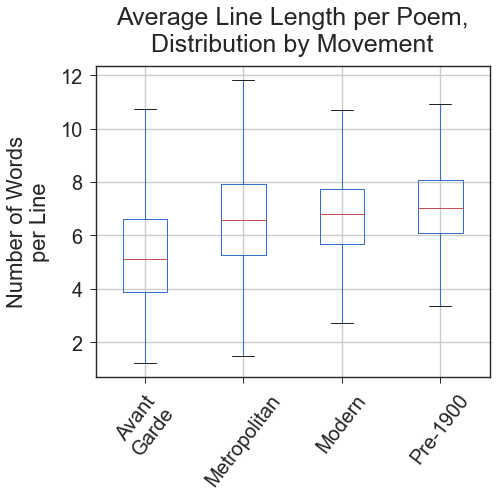

In [38]:
# plot the graph
df.boxplot('avg_len_line', 'movement', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Average Line Length per Poem,\nDistribution by Movement', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of Words\nper Line', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/avg_len_line_boxplot.png', bbox_inches='tight', transparent=True)

plt.show()

- This looks more promising than the statistical tests bore out.
- Avant-Garde clearly has the shortest lines on average, whereas Pre-1900 poetry has the longest.

### Sentiment, polarity

[[go back to the top](#Predicting-Poetic-Movements)]

- I wonder whether any movements tend to be more positive, negative, or neutral.
- I'll create a new string that includes the titles, using the ```lines_titled``` column.
- I'll use VADER to obtain a polarity score, which I can use as a continuous variable, as well as convert to a categorical variable.

In [39]:
# turn each titled poem into a string
df['string_titled'] = df.lines_titled.apply(lambda x: '\n'.join(x))

# confirm
df.loc[0, 'string_titled']

"A Supermarket in California\nWhat thoughts I have of you tonight, Walt Whitman, for I walked down the sidestreets under the trees with a headache self-conscious looking at the full moon.\nIn my hungry fatigue, and shopping for images, I went into the neon fruit supermarket, dreaming of your enumerations!\nWhat peaches and what penumbras! Whole families shopping at night! Aisles full of husbands! Wives in the avocados, babies in the tomatoes!—and you, Garcia Lorca, what were you doing down by the watermelons?\nI saw you, Walt Whitman, childless, lonely old grubber, poking among the meats in the refrigerator and eyeing the grocery boys.\nI heard you asking questions of each: Who killed the pork chops? What price bananas? Are you my Angel?\nI wandered in and out of the brilliant stacks of cans following you, and followed in my imagination by the store detective.\nWe strode down the open corridors together in our solitary fancy tasting artichokes, possessing every frozen delicacy, and nev

In [40]:
%%time

# instantiate VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score, passing in the raw poem
df['sentiment_polarity_score'] = df['string_titled'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

CPU times: user 1min 15s, sys: 262 ms, total: 1min 15s
Wall time: 1min 15s


In [41]:
# convert to categorical variable
conditions = [
    df.sentiment_polarity_score >= .05,
    df.sentiment_polarity_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment_polarity'] = np.select(conditions, choices, 'neutral')

In [42]:
# polarity score stats as a whole
df.sentiment_polarity_score.describe()

count    4307.000000
mean        0.280551
std         0.742653
min        -0.999900
25%        -0.490050
50%         0.644800
75%         0.946200
max         1.000000
Name: sentiment_polarity_score, dtype: float64

In [43]:
# polarity score stats by movement
df.groupby('movement').sentiment_polarity_score.describe().T

movement  avant_garde  metropolitan       modern     pre_1900
count      955.000000   1071.000000  1244.000000  1037.000000
mean         0.234792      0.242937     0.237027     0.413751
std          0.684468      0.757006     0.737744     0.769843
min         -0.998700     -0.999800    -0.998200    -0.999900
25%         -0.420700     -0.607200    -0.526800    -0.361200
50%          0.473800      0.585900     0.542300     0.903900
75%          0.864650      0.934350     0.920050     0.984400
max          0.999500      0.999900     0.999900     1.000000

#### Statistical analysis

In [44]:
# one-way ANOVA
stats.f_oneway(
    df['sentiment_polarity_score'][df['movement'] == 'avant_garde'],
    df['sentiment_polarity_score'][df['movement'] == 'metropolitan'], 
    df['sentiment_polarity_score'][df['movement'] == 'modern'],
    df['sentiment_polarity_score'][df['movement'] == 'pre_1900']
)

F_onewayResult(statistic=14.809404691411396, pvalue=1.3648206914503345e-09)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [45]:
# list of series on which to perform two-sided t-tests
sentiment_polarity_score_list = [
    df['sentiment_polarity_score'][df['movement'] == 'avant_garde'],
    df['sentiment_polarity_score'][df['movement'] == 'metropolitan'], 
    df['sentiment_polarity_score'][df['movement'] == 'modern'],
    df['sentiment_polarity_score'][df['movement'] == 'pre_1900']
]

In [46]:
# test each combination
two_way_tests(sentiment_polarity_score_list)

{(0,
  1): Ttest_indResult(statistic=-0.25285815488182506, pvalue=0.8004035037735806),
 (0,
  2): Ttest_indResult(statistic=-0.07265196593636879, pvalue=0.9420896863240742),
 (0,
  3): Ttest_indResult(statistic=-5.464882994730208, pvalue=5.2137812079548053e-08),
 (1,
  2): Ttest_indResult(statistic=0.18985467548693094, pvalue=0.8494396692879121),
 (1,
  3): Ttest_indResult(statistic=-5.136298556555657, pvalue=3.0599901639529486e-07),
 (2,
  3): Ttest_indResult(statistic=-5.584984247287798, pvalue=2.615446294008786e-08)}

- Looks like there is some significance between Pre-1900 poetry and the other movements, but not amongst the other movements.

### Polarity score -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

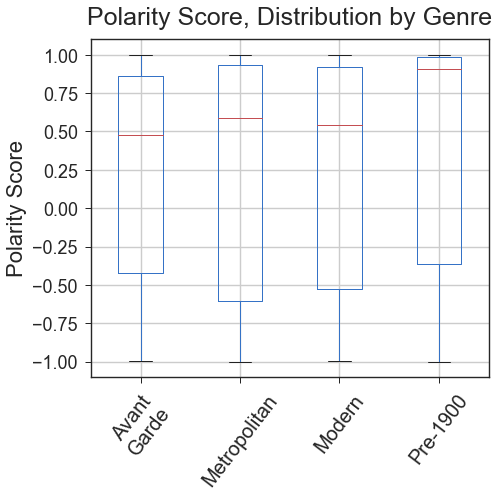

In [47]:
# plot the graph
df.boxplot('sentiment_polarity_score', 'movement', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Polarity Score, Distribution by Genre', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Polarity Score', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/polarity_score_boxplot.png', bbox_inches='tight', transparent=True)

plt.show()

- Pre-1900 poetry is by far the most positive genre of poetry, with Avant-Garde and Modern poetry vying for the least positive poetry.
- Looking at polarity as a categorical variable may be able to tell me more.

### Polarity -- Stacked bar chart

[[go back to the top](#Predicting-Poetic-Movements)]

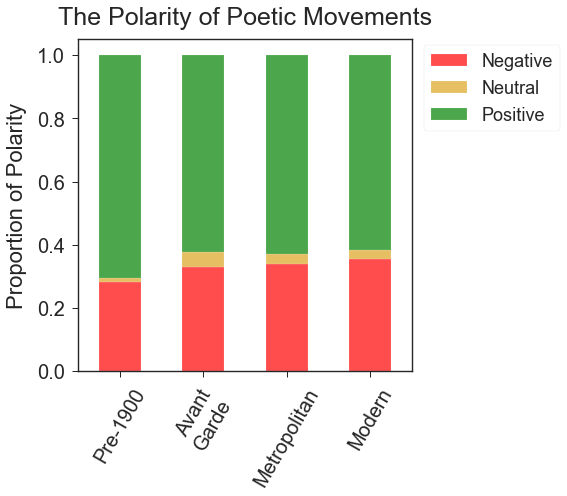

In [48]:
# Proportion of polarity across genre
genre_polarity_dist = df.groupby('movement').sentiment_polarity.\
                        value_counts(normalize=True).unstack().sort_values('negative')

# plot the graph
genre_polarity_dist.plot(kind='bar', stacked=True, figsize=(8,7), 
                               color=['red', 'goldenrod', 'green'], alpha=0.7, fontsize=14)

# prettify the graph
plt.title('The Polarity of Poetic Movements', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Polarity', fontsize=22, labelpad=10)

# obtain x-tick-labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[0] = 'Pre-1900'
# plot the labels and legend
plt.xticks(ticks=locs, labels=labels_pretty, rotation=60, fontsize=20)
plt.yticks(fontsize=20);
plt.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1, bbox_to_anchor=(1.01, 1.01),
          fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/polarity_stackedbar.png', bbox_inches='tight', transparent=True)

plt.show()

- The breakdown shows a surprisingly similar distribution of polarity across movements.
- Avant-Garde poetry has the most neutral poems, though that is still a small percentage of the poems within that movement.

### Sentiment, subjectivity

[[go back to the top](#Predicting-Poetic-Movements)]

- I wonder whether any movements tend to be more or less objective.
- I'll use TextBlob to obtain a sentiment score.

In [49]:
%%time

# create a column with the compound polarity score, passing in the raw poem to TextBlob
df['sentiment_subjectivity_score'] = df['string_titled'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

CPU times: user 7.72 s, sys: 41.8 ms, total: 7.77 s
Wall time: 7.74 s


In [50]:
# subjectivity score stats as a whole
df.sentiment_subjectivity_score.describe()

count    4307.000000
mean        0.478008
std         0.135322
min         0.000000
25%         0.410284
50%         0.484470
75%         0.550000
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

In [51]:
# subjectivity score stast by movement
df.groupby('movement').sentiment_subjectivity_score.describe().T

movement  avant_garde  metropolitan       modern     pre_1900
count      955.000000   1071.000000  1244.000000  1037.000000
mean         0.463313      0.467946     0.480016     0.499522
std          0.152051      0.131243     0.141781     0.110189
min          0.000000      0.000000     0.000000     0.000000
25%          0.389010      0.403229     0.401448     0.443333
50%          0.466276      0.473977     0.486220     0.504321
75%          0.547803      0.538157     0.559187     0.559295
max          1.000000      1.000000     1.000000     0.950000

#### Statistical analysis

In [52]:
# one-way ANOVA
stats.f_oneway(
    df['sentiment_subjectivity_score'][df['movement'] == 'avant_garde'],
    df['sentiment_subjectivity_score'][df['movement'] == 'metropolitan'], 
    df['sentiment_subjectivity_score'][df['movement'] == 'modern'],
    df['sentiment_subjectivity_score'][df['movement'] == 'pre_1900']
)

F_onewayResult(statistic=14.694645968010807, pvalue=1.6123996706134844e-09)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [53]:
# list of series on which to perform two-sided t-tests
sentiment_subjectivity_score_list = [
    df['sentiment_subjectivity_score'][df['movement'] == 'avant_garde'],
    df['sentiment_subjectivity_score'][df['movement'] == 'metropolitan'], 
    df['sentiment_subjectivity_score'][df['movement'] == 'modern'],
    df['sentiment_subjectivity_score'][df['movement'] == 'pre_1900']
]

In [54]:
# test each combination
two_way_tests(sentiment_subjectivity_score_list)

{(0,
  1): Ttest_indResult(statistic=-0.7359465458853823, pvalue=0.4618485076082889),
 (0,
  2): Ttest_indResult(statistic=-2.6531147910210815, pvalue=0.00803271006179469),
 (0,
  3): Ttest_indResult(statistic=-6.119651795782657, pvalue=1.1263879961071897e-09),
 (1,
  2): Ttest_indResult(statistic=-2.11349059295309, pvalue=0.03466561256546819),
 (1,
  3): Ttest_indResult(statistic=-5.9729348528702495, pvalue=2.7282850027289494e-09),
 (2,
  3): Ttest_indResult(statistic=-3.6130885790245495, pvalue=0.00030911992047384835)}

- Avant-Garde and Metropolitan poetries appear to be statistically similar in terms of subjectivity.
- All other combinations show a statistically signficant difference.

### Subjectivity score -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

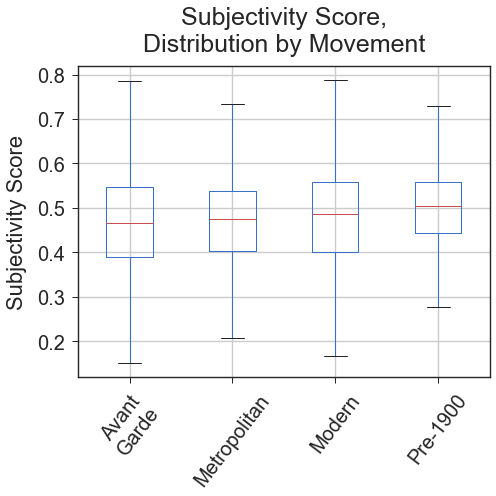

In [55]:
# plot the graph
df.boxplot('sentiment_subjectivity_score', 'movement', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Subjectivity Score,\nDistribution by Movement', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Subjectivity Score', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/subjectivity_score_boxplot.png', bbox_inches='tight', transparent=True)

plt.show()

- Subjectivity seems fairly similar across all genres, all more or less hovering around the midpoint, although again there is a notable difference between Avant-Garde and Pre-1900 poetries.

### Number of end rhymes

[[go back to the top](#Predicting-Poetic-Movements)]

- I would say certain movements definitely rhyme more than others, so let's see if the numbers bear that out.
- Count the number of end rhymes, i.e. lines where the last word rhymes with another line's last word.

In [56]:
%%time

# run custom function to count the number of end rhymes in a poem
df['num_end_rhymes'] = df.clean_lines.apply(end_rhyme_counter)

CPU times: user 2min 56s, sys: 502 ms, total: 2min 57s
Wall time: 2min 57s


In [57]:
# number of end rhymes stats as a whole
df.num_end_rhymes.describe()

count    4307.000000
mean       26.107499
std       158.792001
min         0.000000
25%         0.000000
50%         3.000000
75%        11.000000
max      4165.000000
Name: num_end_rhymes, dtype: float64

In [58]:
# number of end rhymes stats by genre
df.groupby('movement').num_end_rhymes.describe().T

movement  avant_garde  metropolitan       modern     pre_1900
count      955.000000   1071.000000  1244.000000  1037.000000
mean         5.093194     11.777778    12.247588    76.886210
std         19.442511     57.595115    57.808946   305.921111
min          0.000000      0.000000     0.000000     0.000000
25%          0.000000      0.000000     1.000000     6.000000
50%          1.000000      2.000000     3.000000    12.000000
75%          3.000000      6.000000     9.000000    31.000000
max        313.000000    925.000000  1740.000000  4165.000000

#### Statistical analysis

In [59]:
# one-way ANOVA
stats.f_oneway(
    df['num_end_rhymes'][df['movement'] == 'avant_garde'],
    df['num_end_rhymes'][df['movement'] == 'metropolitan'], 
    df['num_end_rhymes'][df['movement'] == 'modern'],
    df['num_end_rhymes'][df['movement'] == 'pre_1900']
)

F_onewayResult(statistic=48.54594245746143, pvalue=7.549665540692152e-31)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [60]:
# list of series on which to perform two-sided t-tests
num_end_rhymes_list = [
    df['num_end_rhymes'][df['movement'] == 'avant_garde'],
    df['num_end_rhymes'][df['movement'] == 'metropolitan'], 
    df['num_end_rhymes'][df['movement'] == 'modern'],
    df['num_end_rhymes'][df['movement'] == 'pre_1900']
]

In [61]:
# test each combination
two_way_tests(num_end_rhymes_list)

{(0,
  1): Ttest_indResult(statistic=-3.4171704521423982, pvalue=0.0006452695018776369),
 (0,
  2): Ttest_indResult(statistic=-3.6684184816959564, pvalue=0.00024986043768259137),
 (0,
  3): Ttest_indResult(statistic=-7.238684502596709, pvalue=6.441253578017886e-13),
 (1,
  2): Ttest_indResult(statistic=-0.1952991078579016, pvalue=0.8451759490332627),
 (1,
  3): Ttest_indResult(statistic=-6.840984735825208, pvalue=1.0273006355408276e-11),
 (2,
  3): Ttest_indResult(statistic=-7.297974294398714, pvalue=4.0144598877415216e-13)}

- All tests other than that between Metropolitan and Modern poetries show statistical signficance.

### Number of end rhymes -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

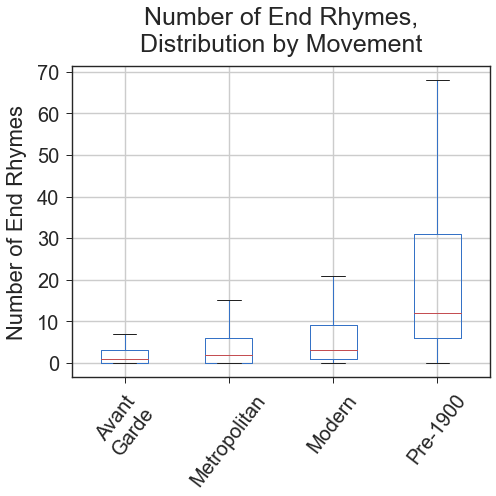

In [62]:
# plot the graph
df.boxplot('num_end_rhymes', 'movement', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Number of End Rhymes,\nDistribution by Movement', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of End Rhymes', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/num_end_rhymes_boxplot.png', bbox_inches='tight', transparent=True)

plt.show()

- Unsurprisingly, pre-1900 poetry is far above the rest.
- Similarly unsurprising, avant-garde poetry tends to not have very few end rhymes.

### Ratio of end rhymes

[[go back to the top](#Predicting-Poetic-Movements)]

- Looking at the ratio of end rhymes to the length of the poem may give me a better idea about how prevalent any rhyme scheme actually is.

In [63]:
# create column of the ratio of end rhymes to the total lines
df['end_rhyme_ratio'] = df.num_end_rhymes / df.num_lines

In [64]:
# end rhyme ratio stats as a whole
df.end_rhyme_ratio.describe()

count    4307.000000
mean        0.302165
std         0.561589
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max        13.846154
Name: end_rhyme_ratio, dtype: float64

In [65]:
# end rhyme ratio stats by movement
df.groupby('movement').end_rhyme_ratio.describe().T

movement  avant_garde  metropolitan       modern     pre_1900
count      955.000000   1071.000000  1244.000000  1037.000000
mean         0.073593      0.170163     0.247504     0.714566
std          0.134850      0.448386     0.276827     0.868623
min          0.000000      0.000000     0.000000     0.000000
25%          0.000000      0.000000     0.020306     0.325000
50%          0.024390      0.063492     0.184429     0.500000
75%          0.090909      0.187500     0.378161     0.828571
max          1.071429      9.700000     3.140794    13.846154

#### Statistical analysis

In [66]:
# one-way ANOVA
stats.f_oneway(
    df['end_rhyme_ratio'][df['movement'] == 'avant_garde'],
    df['end_rhyme_ratio'][df['movement'] == 'metropolitan'], 
    df['end_rhyme_ratio'][df['movement'] == 'modern'],
    df['end_rhyme_ratio'][df['movement'] == 'pre_1900']
)

F_onewayResult(statistic=321.46616836082023, pvalue=2.4863319898283616e-188)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [67]:
# list of series on which to perform two-sided t-tests
end_rhyme_ratio_list = [
    df['end_rhyme_ratio'][df['movement'] == 'avant_garde'],
    df['end_rhyme_ratio'][df['movement'] == 'metropolitan'], 
    df['end_rhyme_ratio'][df['movement'] == 'modern'],
    df['end_rhyme_ratio'][df['movement'] == 'pre_1900']
]

In [68]:
# test each combination
two_way_tests(end_rhyme_ratio_list)

{(0,
  1): Ttest_indResult(statistic=-6.402372302678296, pvalue=1.8961800689979426e-10),
 (0,
  2): Ttest_indResult(statistic=-17.855321560302972, pvalue=1.0800212770159733e-66),
 (0,
  3): Ttest_indResult(statistic=-22.554601204625648, pvalue=1.69341071666231e-100),
 (1,
  2): Ttest_indResult(statistic=-5.065033789783985, pvalue=4.4059175393871125e-07),
 (1,
  3): Ttest_indResult(statistic=-18.16336634410147, pvalue=1.3205747411111484e-68),
 (2,
  3): Ttest_indResult(statistic=-17.906168508557354, pvalue=3.419190673789586e-67)}

- All results here show statistical signficance, so this may be the prefered metric over the number of end rhymes.
- This also connects well with my [earlier analysis](#Number-of-lines) of the number of lines, in delineating between Metropolitan and Modern poetries. 
    - While they shared statistically similar numbers of the number of end rhymes, Modern poetry tends to be shorter (and thus have a higher ratio of rhymes to lines), whereas Metropolitan poetry tends to be longer (and thus have a higher ratio of rhymes to lines).

### Ratio of end rhymes -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

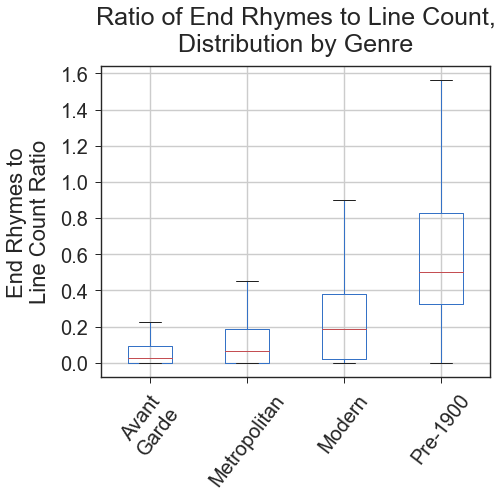

In [69]:
# plot the graph
df.boxplot('end_rhyme_ratio', 'movement', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Ratio of End Rhymes to Line Count,\nDistribution by Genre', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('End Rhymes to\nLine Count Ratio', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/ratio_end_rhymes_boxplot.png', bbox_inches='tight', transparent=True)

plt.show()

- This plot does seem to show the differences more clearly.
    - Pre-1900 poetry is still in a strong lead, while there is now see some separation between Metropolitan and Modern genres.
    - Modern makes a surprise appearance in second place.
    - Everything else makes sense from a poetry standpoint.
- I'll check if this is too strongly correlated with the number of end rhymes.

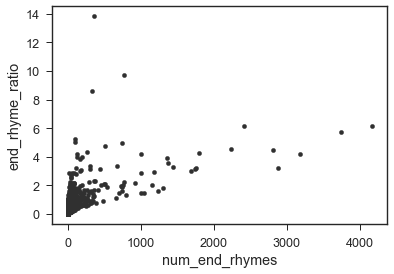

In [70]:
df.plot.scatter('num_end_rhymes', 'end_rhyme_ratio');

In [71]:
# check correlation
df.num_end_rhymes.corr(df.end_rhyme_ratio)

0.5872658675753575

- They are fairly positively correlated, but there is no definite need to drop either variable.
    
### End rhymes, categorical

[[go back to the top](#Predicting-Poetic-Movements)]

- **NOTE**: Feel free to play around with the metric; first, I tried separating based on 0 end rhymes vs any number of end rhymes.
    - Increasing the 0 value yielded more interesting results (and also weeds out some incidental end rhymes, including those of repeated words).
    - Another tactic is setting a minimum ratio of end rhymes to lines, as seen below.

In [72]:
# create a yes or no column for whether or not end rhymes occur at least 10% of the time
df['end_rhyme'] = np.where(df.end_rhyme_ratio >= 0.25, 1, 0)

In [73]:
# proportion as a whole
df.end_rhyme.value_counts(normalize=True)

0    0.604597
1    0.395403
Name: end_rhyme, dtype: float64

In [74]:
# proportion across movements
df.groupby('movement').end_rhyme.value_counts(normalize=True)

movement      end_rhyme
avant_garde   0            0.920419
              1            0.079581
metropolitan  0            0.803922
              1            0.196078
modern        0            0.567524
              1            0.432476
pre_1900      1            0.847637
              0            0.152363
Name: end_rhyme, dtype: float64

### End rhymes -- Stacked bar chart

[[go back to the top](#Predicting-Poetic-Movements)]

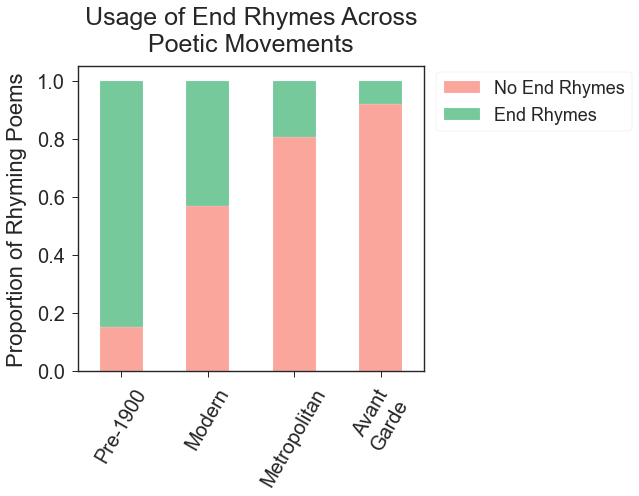

In [75]:
# Proportion of end rhymes across movements
genre_polarity_dist = df.groupby('movement').end_rhyme.value_counts(normalize=True).unstack().sort_values(0)

# plot the graph
genre_polarity_dist.plot(kind='bar', stacked=True, figsize=(9,7), 
                               color=['salmon', 'mediumseagreen'], alpha=.70, fontsize=14)

# prettify the graph
plt.title('Usage of End Rhymes Across\nPoetic Movements', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Rhyming Poems', fontsize=22, labelpad=10)

# obtain x-tick-labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[0] = 'Pre-1900'
# plot the labels and and legends
plt.xticks(ticks=locs, labels=labels_pretty, rotation=60, fontsize=20)
plt.yticks(fontsize=20);
plt.legend(['No End Rhymes', 'End Rhymes'], facecolor='white', framealpha=1, bbox_to_anchor=(1.01, 1.01),
          fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/end_rhymes_stackedbar.png', bbox_inches='tight', transparent=True)

plt.show()

- Another graph showing similar results more clearly.

### Syllables per word

[[go back to the top](#Predicting-Poetic-Movements)]

- Count the number of total syllables.
- Divide by number of words per poem.

In [76]:
# divide number of syllables by number of words
df['avg_syllables_word'] = df.lines_titled.apply(syllable_counter) / df.num_words

In [77]:
# average syllables per word stats as a whole
df.avg_syllables_word.describe()

count    4307.000000
mean        1.214609
std         0.087841
min         1.000000
25%         1.155752
50%         1.204545
75%         1.261905
max         1.771930
Name: avg_syllables_word, dtype: float64

In [78]:
# average syllables per word stats by movement
df.groupby('movement').avg_syllables_word.describe().T

movement  avant_garde  metropolitan       modern     pre_1900
count      955.000000   1071.000000  1244.000000  1037.000000
mean         1.233820      1.246693     1.210349     1.168892
std          0.091017      0.095235     0.081878     0.059271
min          1.000000      1.000000     1.000000     1.000000
25%          1.170836      1.186504     1.160714     1.128205
50%          1.226236      1.237013     1.205352     1.165266
75%          1.285714      1.293284     1.253031     1.203627
max          1.674419      1.750000     1.771930     1.475000

- The numbers look fairly similar. I'll do some statistical analyses.

#### Statistical analysis

In [79]:
# one-way ANOVA
stats.f_oneway(
    df['avg_syllables_word'][df['movement'] == 'avant_garde'],
    df['avg_syllables_word'][df['movement'] == 'metropolitan'], 
    df['avg_syllables_word'][df['movement'] == 'modern'],
    df['avg_syllables_word'][df['movement'] == 'pre_1900']
)

F_onewayResult(statistic=176.73842807201524, pvalue=4.621908484180138e-108)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [80]:
# list of series on which to perform two-sided t-tests
avg_syllables_word_list = [
    df['avg_syllables_word'][df['movement'] == 'avant_garde'],
    df['avg_syllables_word'][df['movement'] == 'metropolitan'], 
    df['avg_syllables_word'][df['movement'] == 'modern'],
    df['avg_syllables_word'][df['movement'] == 'pre_1900']
]

In [81]:
# test each combination
two_way_tests(avg_syllables_word_list)

{(0,
  1): Ttest_indResult(statistic=-3.1012698106917918, pvalue=0.0019534972541469034),
 (0,
  2): Ttest_indResult(statistic=6.345928549454994, pvalue=2.676988756066352e-10),
 (0,
  3): Ttest_indResult(statistic=19.008560801641043, pvalue=3.63593331677169e-74),
 (1,
  2): Ttest_indResult(statistic=9.873342686306662, pvalue=1.50602123466246e-22),
 (1,
  3): Ttest_indResult(statistic=22.434710215561065, pvalue=3.9416176259391093e-100),
 (2,
  3): Ttest_indResult(statistic=13.602247431745523, pvalue=1.424785449445956e-40)}

- This variable appears to be statistically significant across each combination of movements.

### Syllables per word -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

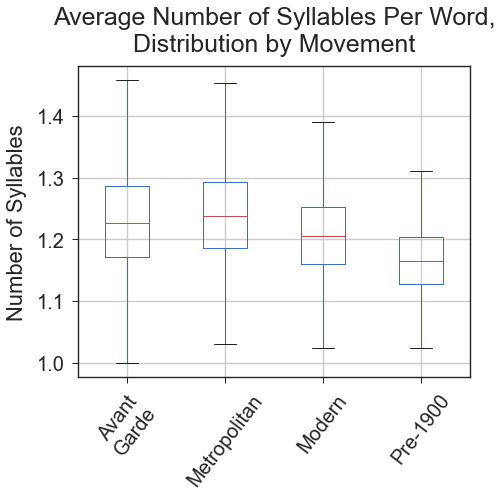

In [82]:
# plot the graph
df.boxplot('avg_syllables_word', 'movement', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Average Number of Syllables Per Word,\nDistribution by Movement', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of Syllables', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/avg_syllables_word_boxplot.png', bbox_inches='tight', transparent=True)

plt.show()

- Surprisingly, in my mind at least, Romantic and Victorian (Pre-1900) are among the simplest vocabularies (words with the least amount of syllables).
- The arguably more intellectual movements (Metropolitan and Avant-Garde) rank among the most complex.

### Lexical richness

[[go back to the top](#Predicting-Poetic-Movements)]

- Count the number of unique words.
- Divide by number of words per poem.

In [83]:
# divide number of unique words by total words
df['lexical_richness'] = df.lines_titled.apply(unique_word_counter) / df.num_words
df.lexical_richness.head()

0    0.609929
1    0.499387
2    0.479167
3    0.666667
4    0.436057
Name: lexical_richness, dtype: float64

In [84]:
# lexical richness as a whole
df.lexical_richness.describe()

count    4307.000000
mean        0.657667
std         0.125099
min         0.066667
25%         0.580302
50%         0.666667
75%         0.740260
max         1.000000
Name: lexical_richness, dtype: float64

In [85]:
# lexical richness as a whole by movement
df.groupby('movement').lexical_richness.describe().T

movement  avant_garde  metropolitan       modern     pre_1900
count      955.000000   1071.000000  1244.000000  1037.000000
mean         0.696184      0.655895     0.653112     0.629488
std          0.125872      0.122490     0.117600     0.127190
min          0.287405      0.066667     0.082680     0.216450
25%          0.616701      0.581689     0.581149     0.550794
50%          0.701923      0.657459     0.662116     0.645833
75%          0.779180      0.730769     0.730913     0.725000
max          1.000000      1.000000     1.000000     0.961538

- Avant-Garde appears to be the most rich within every quartile, the mean, and the minimum.
- The other three movements have very similar numbers, other than the minimum.

#### Statistical analysis

In [86]:
# one-way ANOVA
stats.f_oneway(
    df['lexical_richness'][df['movement'] == 'avant_garde'],
    df['lexical_richness'][df['movement'] == 'metropolitan'], 
    df['lexical_richness'][df['movement'] == 'modern'],
    df['lexical_richness'][df['movement'] == 'pre_1900']
)

F_onewayResult(statistic=49.98600790750953, pvalue=9.484488103478223e-32)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [87]:
# list of series on which to perform two-sided t-tests
lexical_richness_list = [
    df['lexical_richness'][df['movement'] == 'avant_garde'],
    df['lexical_richness'][df['movement'] == 'metropolitan'], 
    df['lexical_richness'][df['movement'] == 'modern'],
    df['lexical_richness'][df['movement'] == 'pre_1900']
]

In [88]:
# test each combination
two_way_tests(lexical_richness_list)

{(0,
  1): Ttest_indResult(statistic=7.2945674380174355, pvalue=4.279891666798249e-13),
 (0,
  2): Ttest_indResult(statistic=8.256095713084413, pvalue=2.5653106934668424e-16),
 (0,
  3): Ttest_indResult(statistic=11.750201509514143, pvalue=7.18970940742516e-31),
 (1,
  2): Ttest_indResult(statistic=0.5570741370703747, pvalue=0.5775306761186816),
 (1,
  3): Ttest_indResult(statistic=4.855911079230304, pvalue=1.2865119948974797e-06),
 (2,
  3): Ttest_indResult(statistic=4.602858590058292, pvalue=4.396260725998247e-06)}

- This variable appears to be statistically significant across every combination of movements other than between Metropolitan and Modern, which makes sense when looking at the descriptive stats across movements.

### Lexical richness -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

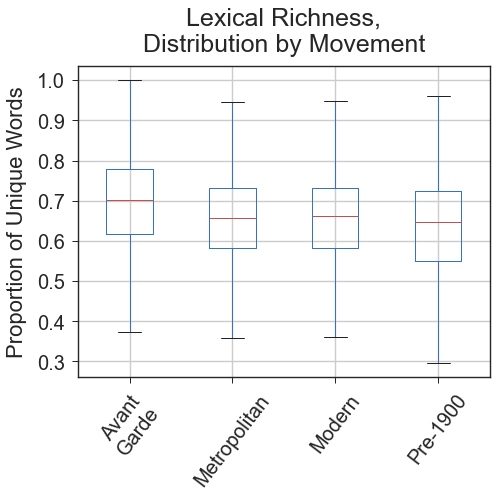

In [89]:
# plot the graph
df.boxplot('lexical_richness', 'movement', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Lexical Richness,\nDistribution by Movement', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Unique Words', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/lexical_richness_boxplot.png', bbox_inches='tight', transparent=True)

plt.show()

- Avant-Garde poetry is indeed the richest, while Pre-1900 seems to be the most repetitious, though fairly similar to Metropolitan and Modern.
- Pre-1900 also has the most variance, across all quartiles.

# Step 4: Natural language processing

[[go back to the top](#Predicting-Poetic-Movements)]

- Process the text and look at the most frequent words.
- First, prepare a list of stop words. This will include:
    - NLTK stop words.
    - Older English equivalents to those stop words.
    - Poet names (because some may have gotten through in the scraping process), minus any names that may also be used as words.
    - HTML tags that may have gotten through the scraping process.
    - Words of questionable value discovered in the first round of EDA.

In [90]:
# list of names that may also be used as words
name_keeps = [
    'basil', 'bell', 'bill', 'bottoms', 'brooks', 'brown', 
    'burns', 'butler', 'christian', 'clerk', 'crane', 
    'elephant', 'frank', 'field', 'gallup', 'good', 'guest', 
    'hands', 'hood', 'hooks', 'hunt', 'hunter', 'knight', 
    'lamb', 'lazarus', 'love', 'mare', 'more', 'mark', 
    'moody', 'peacock', 'pound', 'ransom', 'riding', 'savage', 
    'sir', 'white']

# optional
# ['bob', 'dick', 'lee', 'maya', 'sappho', 'sexton', 
#  'smith', 'spender', 'twain', 'walker']

In [91]:
# instantiate empty set
stop_names = set()

# add first and last names to stop_names
for poet in df.poet:
    name_split = poet.lower().split()
    for name in name_split:
        if name not in name_keeps:
            stop_names.add(name)
            
# convert to list
stop_names = list(stop_names)

# take a look at a sample
stop_names[:10]

['douglas',
 'michael',
 'dylan',
 'joanna',
 'hughes',
 'wieners',
 'mcalmon',
 'wallace',
 'palmer',
 'conrad']

In [92]:
# start with NLTK stop words
stop_words = stopwords.words('english')

# add any html tags that may have snuck through
stop_words.extend(['em', 'div', 'href', 'p'])

# add old-timey stop words
stop_words.extend(old_timers())

# words found in the initial round of EDA that 
# don't provide much meaning
stop_words.extend(['one', 'like', 'would', 'upon', 
                   'yet', 'may', 'could'])

# add the names from above
stop_words.extend(stop_names)

- Create a clean string column.

In [93]:
%%time

# create column using custom text processing function
# NOTE: includes lemmatization
df['string_cleaned'] = df.string_titled.apply(
    lambda x: clean_text(x, stop_words))

CPU times: user 1min 35s, sys: 9.76 s, total: 1min 45s
Wall time: 1min 45s


In [94]:
# check out an example
print(f'BEFORE:\n{df.loc[0, "string_titled"]}')
print('\n' + '-' * 75 + '\n')
print(f'AFTER:\n{df.loc[0, "string_cleaned"]}')

BEFORE:
A Supermarket in California
What thoughts I have of you tonight, Walt Whitman, for I walked down the sidestreets under the trees with a headache self-conscious looking at the full moon.
In my hungry fatigue, and shopping for images, I went into the neon fruit supermarket, dreaming of your enumerations!
What peaches and what penumbras! Whole families shopping at night! Aisles full of husbands! Wives in the avocados, babies in the tomatoes!—and you, Garcia Lorca, what were you doing down by the watermelons?
I saw you, Walt Whitman, childless, lonely old grubber, poking among the meats in the refrigerator and eyeing the grocery boys.
I heard you asking questions of each: Who killed the pork chops? What price bananas? Are you my Angel?
I wandered in and out of the brilliant stacks of cans following you, and followed in my imagination by the store detective.
We strode down the open corridors together in our solitary fancy tasting artichokes, possessing every frozen delicacy, and nev

### Total word counts and vocabulary 

[[go back to the top](#Predicting-Poetic-Movements)]

#### Before processing

In [95]:
# join all pre-processed poems into one string
big_string_pre = ' '.join(df.string_titled)
big_string_pre[:1000]

'A Supermarket in California\nWhat thoughts I have of you tonight, Walt Whitman, for I walked down the sidestreets under the trees with a headache self-conscious looking at the full moon.\nIn my hungry fatigue, and shopping for images, I went into the neon fruit supermarket, dreaming of your enumerations!\nWhat peaches and what penumbras! Whole families shopping at night! Aisles full of husbands! Wives in the avocados, babies in the tomatoes!—and you, Garcia Lorca, what were you doing down by the watermelons?\nI saw you, Walt Whitman, childless, lonely old grubber, poking among the meats in the refrigerator and eyeing the grocery boys.\nI heard you asking questions of each: Who killed the pork chops? What price bananas? Are you my Angel?\nI wandered in and out of the brilliant stacks of cans following you, and followed in my imagination by the store detective.\nWe strode down the open corridors together in our solitary fancy tasting artichokes, possessing every frozen delicacy, and nev

In [96]:
# split string into all words in corpus
all_words = big_string_pre.split()

# total words
len(all_words)

1165726

In [97]:
# unique words (vocabulary)
len(list(set(all_words)))

119285

#### After lemmatizing and removing stop words

In [98]:
# join all processed poems into one string
big_string_proc = ' '.join(df.string_cleaned)
big_string_proc[:1000]

'supermarket california thought tonight walt whitman walk sidestreets tree headache self conscious look full moon hungry fatigue shopping image neon fruit supermarket dream enumeration peach penumbra whole family shopping night aisle full husband wife avocado baby tomato garcia lorca watermelon saw walt whitman childless lonely old grubber poke among meat refrigerator eye grocery boy heard ask question kill pork chop price banana angel wander brilliant stack follow follow imagination store detective strode open corridor together solitary fancy taste artichoke possess every frozen delicacy never passing cashier walt whitman door close hour way beard point tonight touch book dream odyssey supermarket feel absurd walk night solitary street tree add shade shade light house lonely stroll dream lose america love past blue automobile driveway home silent cottage dear father graybeard lonely old courage teacher america charon quit pole ferry get smoking bank stood watch boat disappear black wa

In [99]:
# split string into processed words in corpus
all_words_proc = big_string_proc.split()

# total processed words
len(all_words_proc)

585256

In [100]:
# unique processed words (vocabulary)
len(list(set(all_words_proc)))

36443

## Most frequent words

[[go back to the top](#Predicting-Poetic-Movements)]

- Use processed text.

In [101]:
# create dictionary of word counts
fdist = FreqDist(all_words_proc)

# convert word counts to dataframe
fdist_df = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
fdist_df = fdist_df.sort_values('word_count', ascending=False)

In [102]:
# look at the top 25 words in the processed corpus
top_25 = fdist_df.iloc[:25,:]
top_25

word_count
come         3256
love         3247
say          2959
see          2571
day          2514
make         2501
eye          2368
know         2316
life         2243
man          2192
night        2178
time         2079
light        1965
old          1951
heart        1816
hand         1728
thing        1712
look         1626
take         1554
still        1554
long         1544
never        1534
world        1513
white        1499
face         1417

### Most frequent words overall

[[go back to the top](#Predicting-Poetic-Movements)]

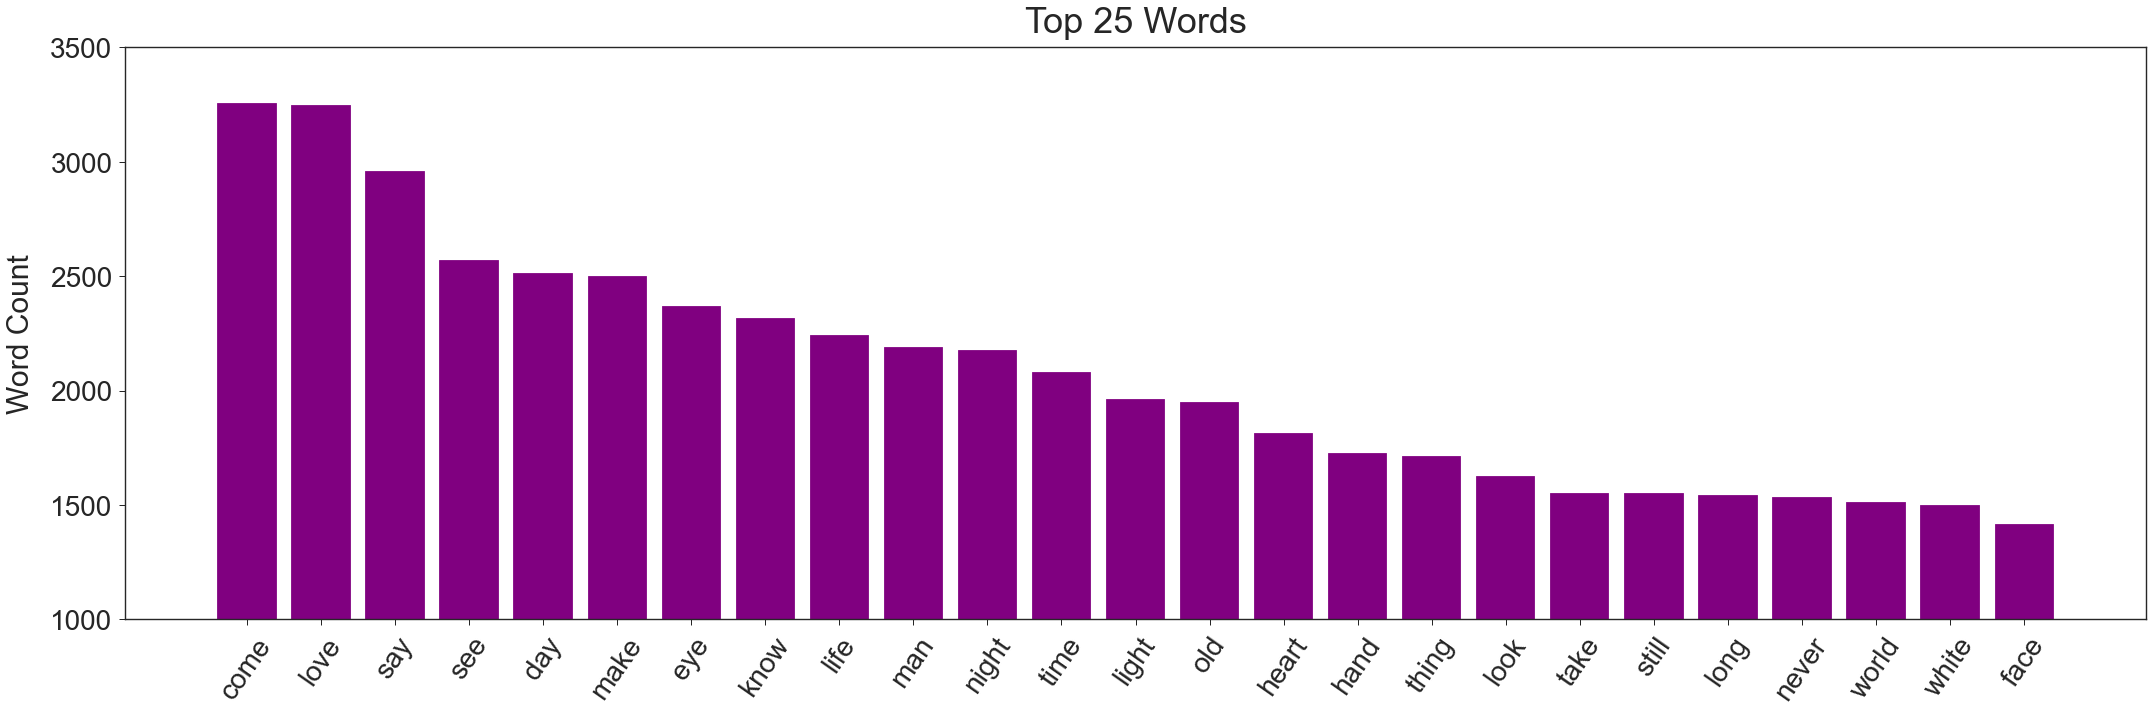

In [103]:
# create labels and prettify the plot
plt.figure(figsize=(30,10))
plt.title('Top 25 Words', fontsize=36, pad=15)
plt.ylabel('Word Count', fontsize=30, labelpad=15)
plt.xticks(rotation=55, fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(bottom=1000, top=3500)

# plot top 25 words
plt.bar(top_25.index, top_25.word_count, color='purple')

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/top25_words_bar.png', bbox_inches='tight', transparent=True)

plt.show()

### Most frequent words by genre

[[go back to the top](#Predicting-Poetic-Movements)]

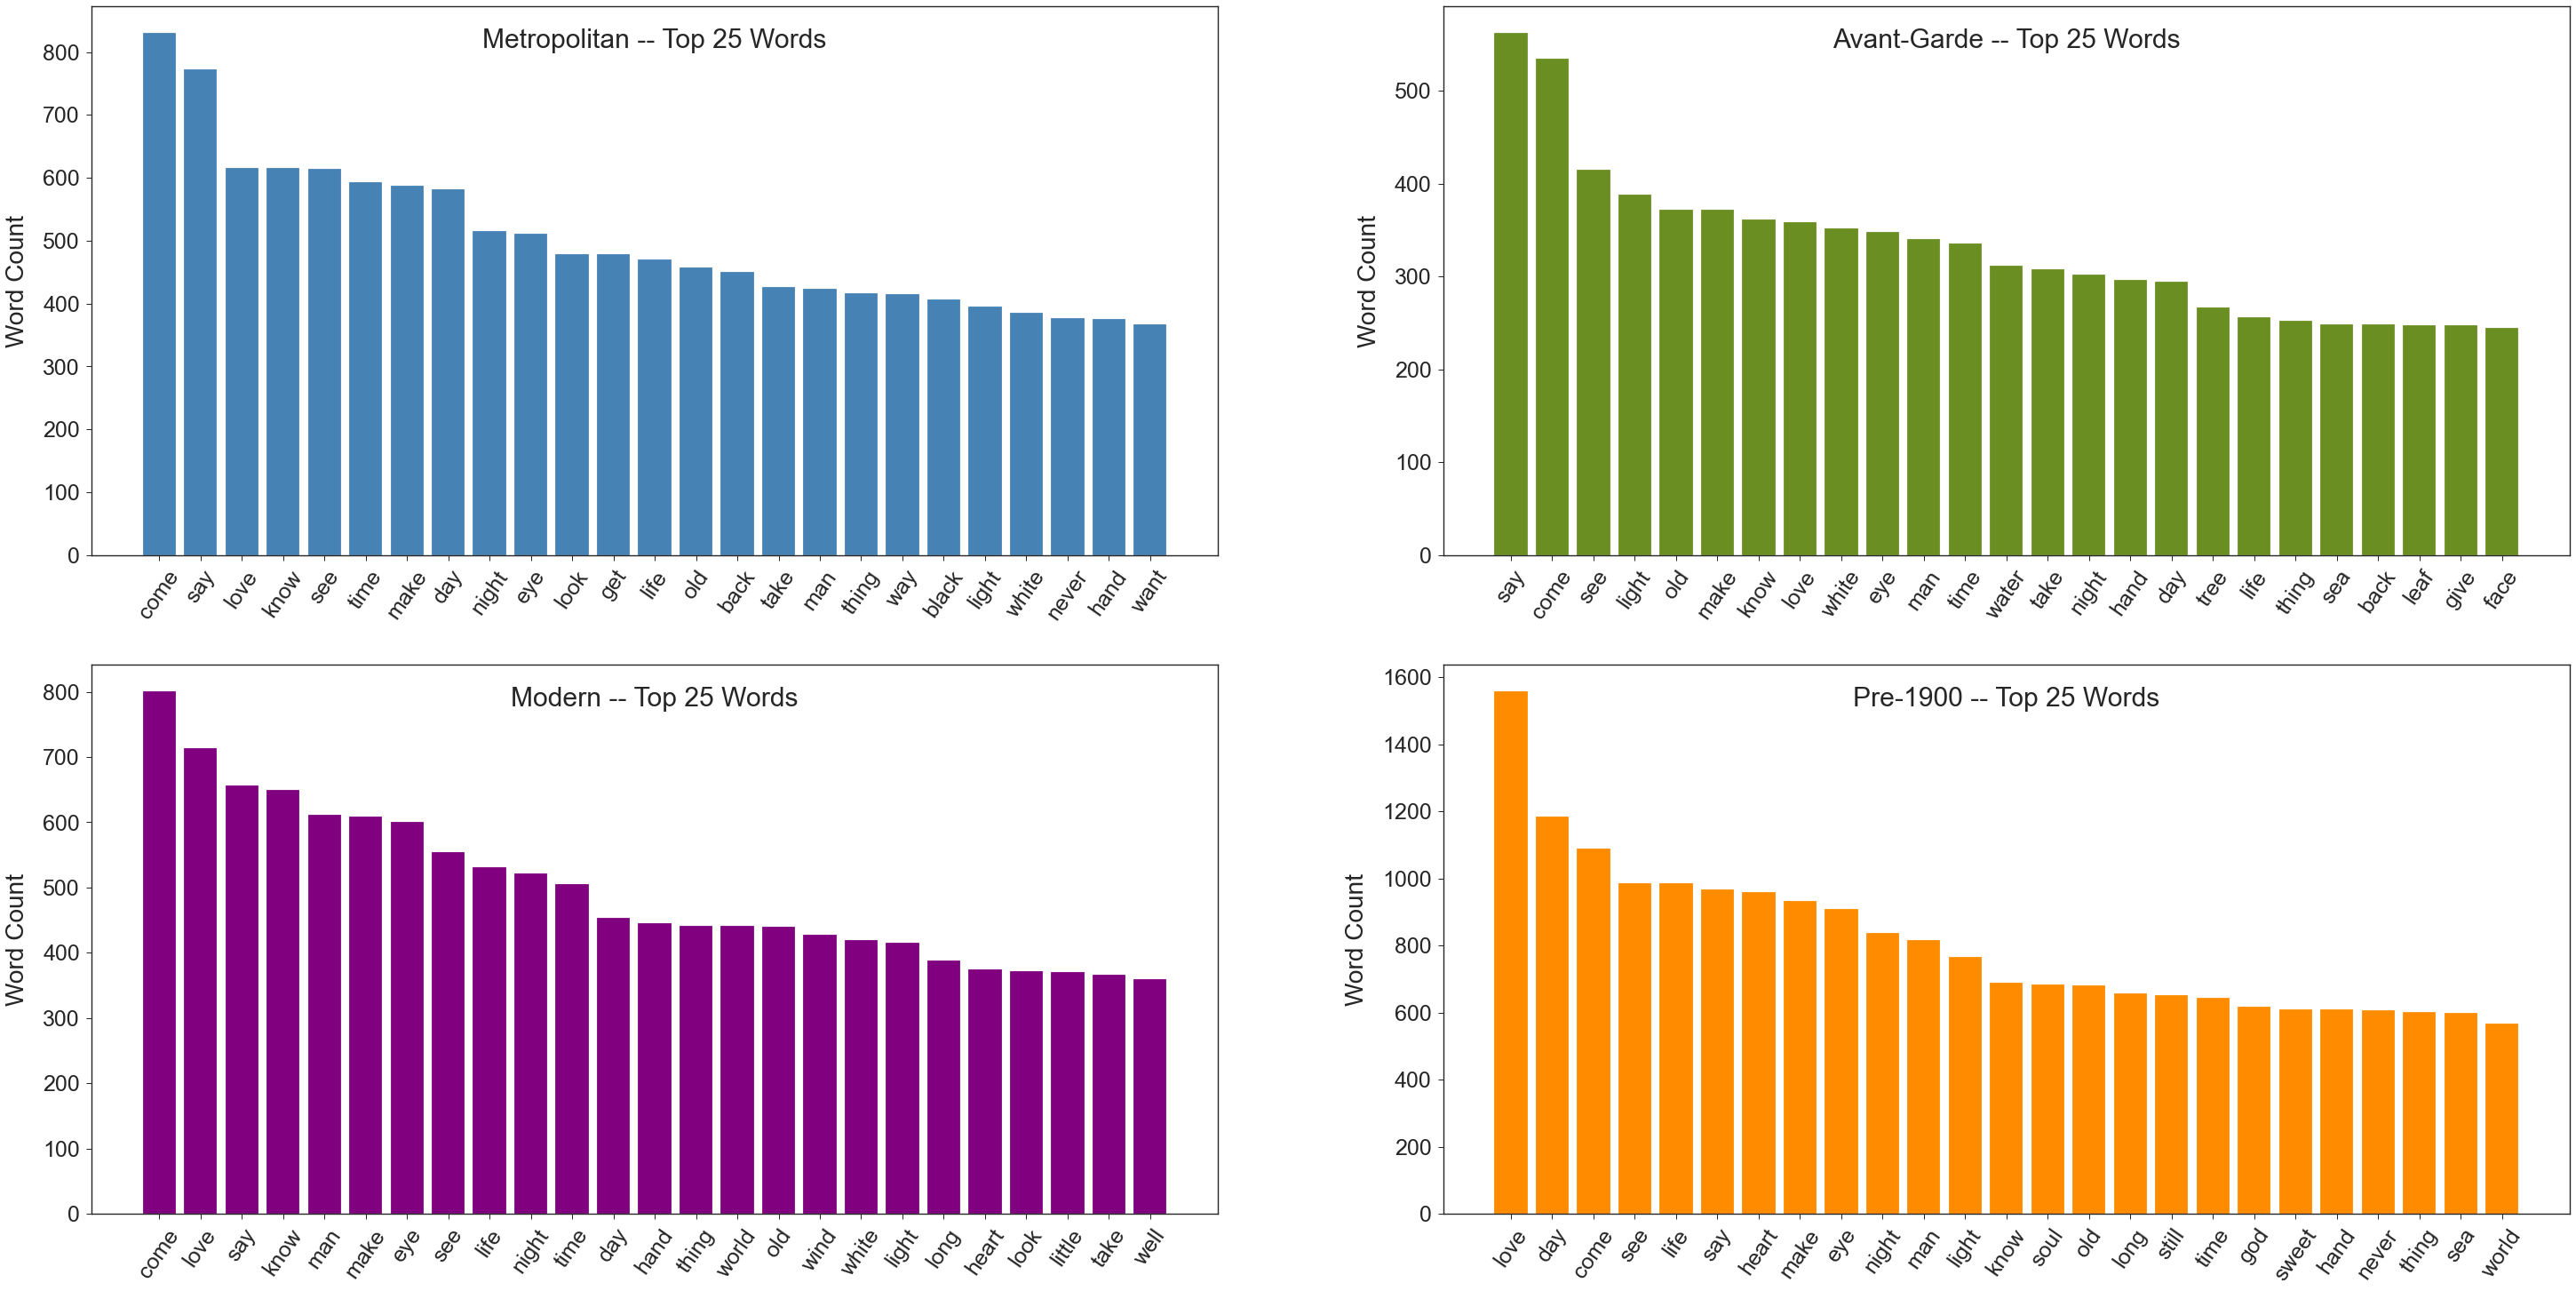

In [104]:
plt.figure(figsize=(50,25))

movements = list(df.movement.unique())

for i, movement in enumerate(movements):
    # create a series of processed poem strings
    movement_string_series = df[df.movement == movement].string_cleaned
    
    # convert the series to one big string
    movement_big_string = ' '.join(movement_string_series)
    
    # split the big string so I get all words in the movement
    movement_words = movement_big_string.split()
    
    # create dictionary of word counts
    fdist = FreqDist(movement_words)
    
    # convert word counts to dataframe
    fdist_df = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
    fdist_df = fdist_df.sort_values('word_count', ascending=False)
    
    # look at the top 25 words for the genre
    top_25 = fdist_df.iloc[:25,:]

    # set dimension of plots
    nrows = 2
    ncols = 2

    # list of colors
    colors = ['steelblue', 'olivedrab', 'purple', 'darkorange']
    
    # plot
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'{movement.title().replace("_", "-")} -- Top 25 Words', fontsize=30, pad=15, x=0.5, y=0.9)
    plt.ylabel('Word Count', fontsize=28, labelpad=15)
    plt.xticks(rotation=55, fontsize=25)
    plt.yticks(fontsize=25)
    plt.bar(top_25.index, top_25.word_count, color=colors[i])
              
# # uncomment to save
# plt.savefig('charts/top25_words_movement_bar.png', bbox_inches='tight', transparent=True)

### Word cloud overall

[[go back to the top](#Predicting-Poetic-Movements)]

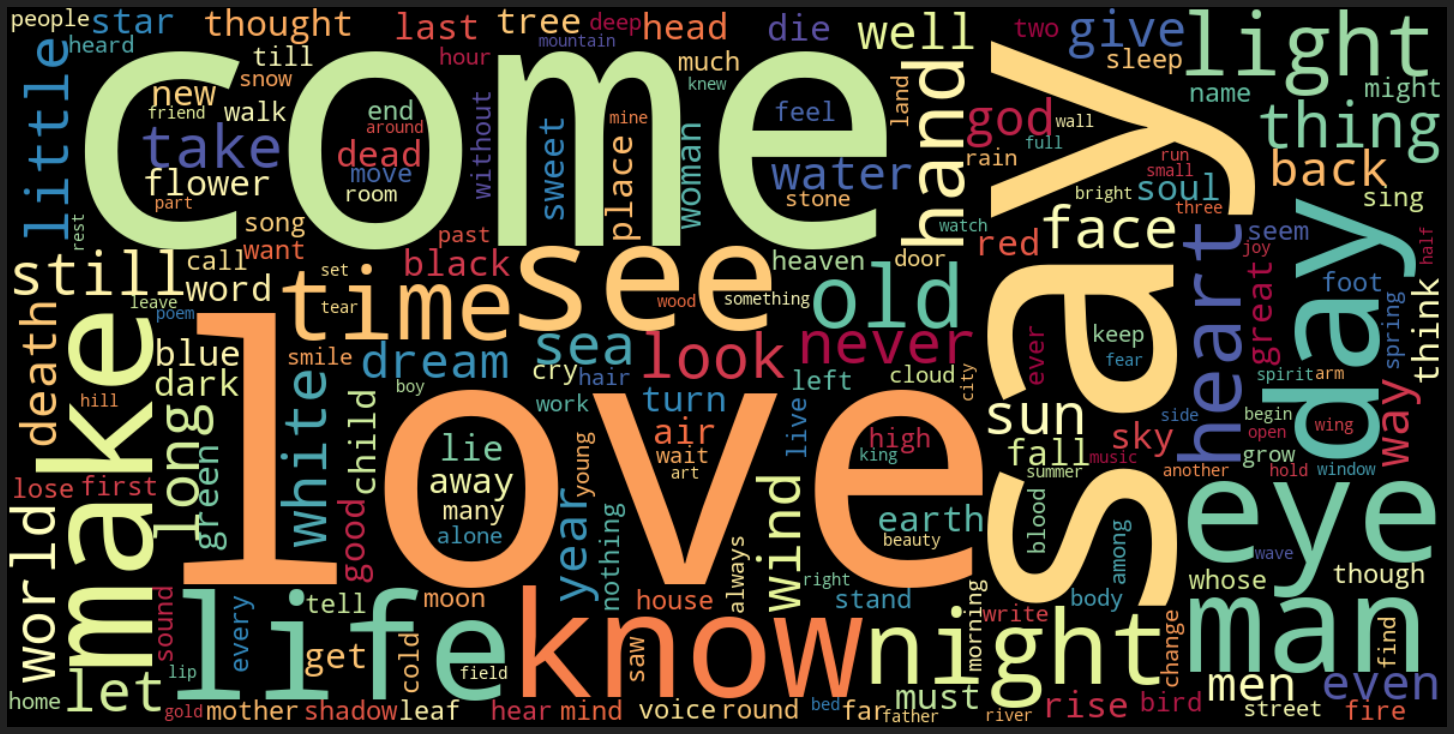

In [105]:
# create a dictionary for easy word cloud creation
word_dict = dict(Counter(all_words_proc))

# create word cloud
wordcloud = WordCloud(colormap='Spectral', width=1200, height=600).generate_from_frequencies(word_dict)

# plot word cloud
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# # uncomment to save
# plt.savefig('charts/word_cloud_overall.png', bbox_inches='tight', transparent=True)

### Word clouds by genre

[[go back to the top](#Predicting-Poetic-Movements)]

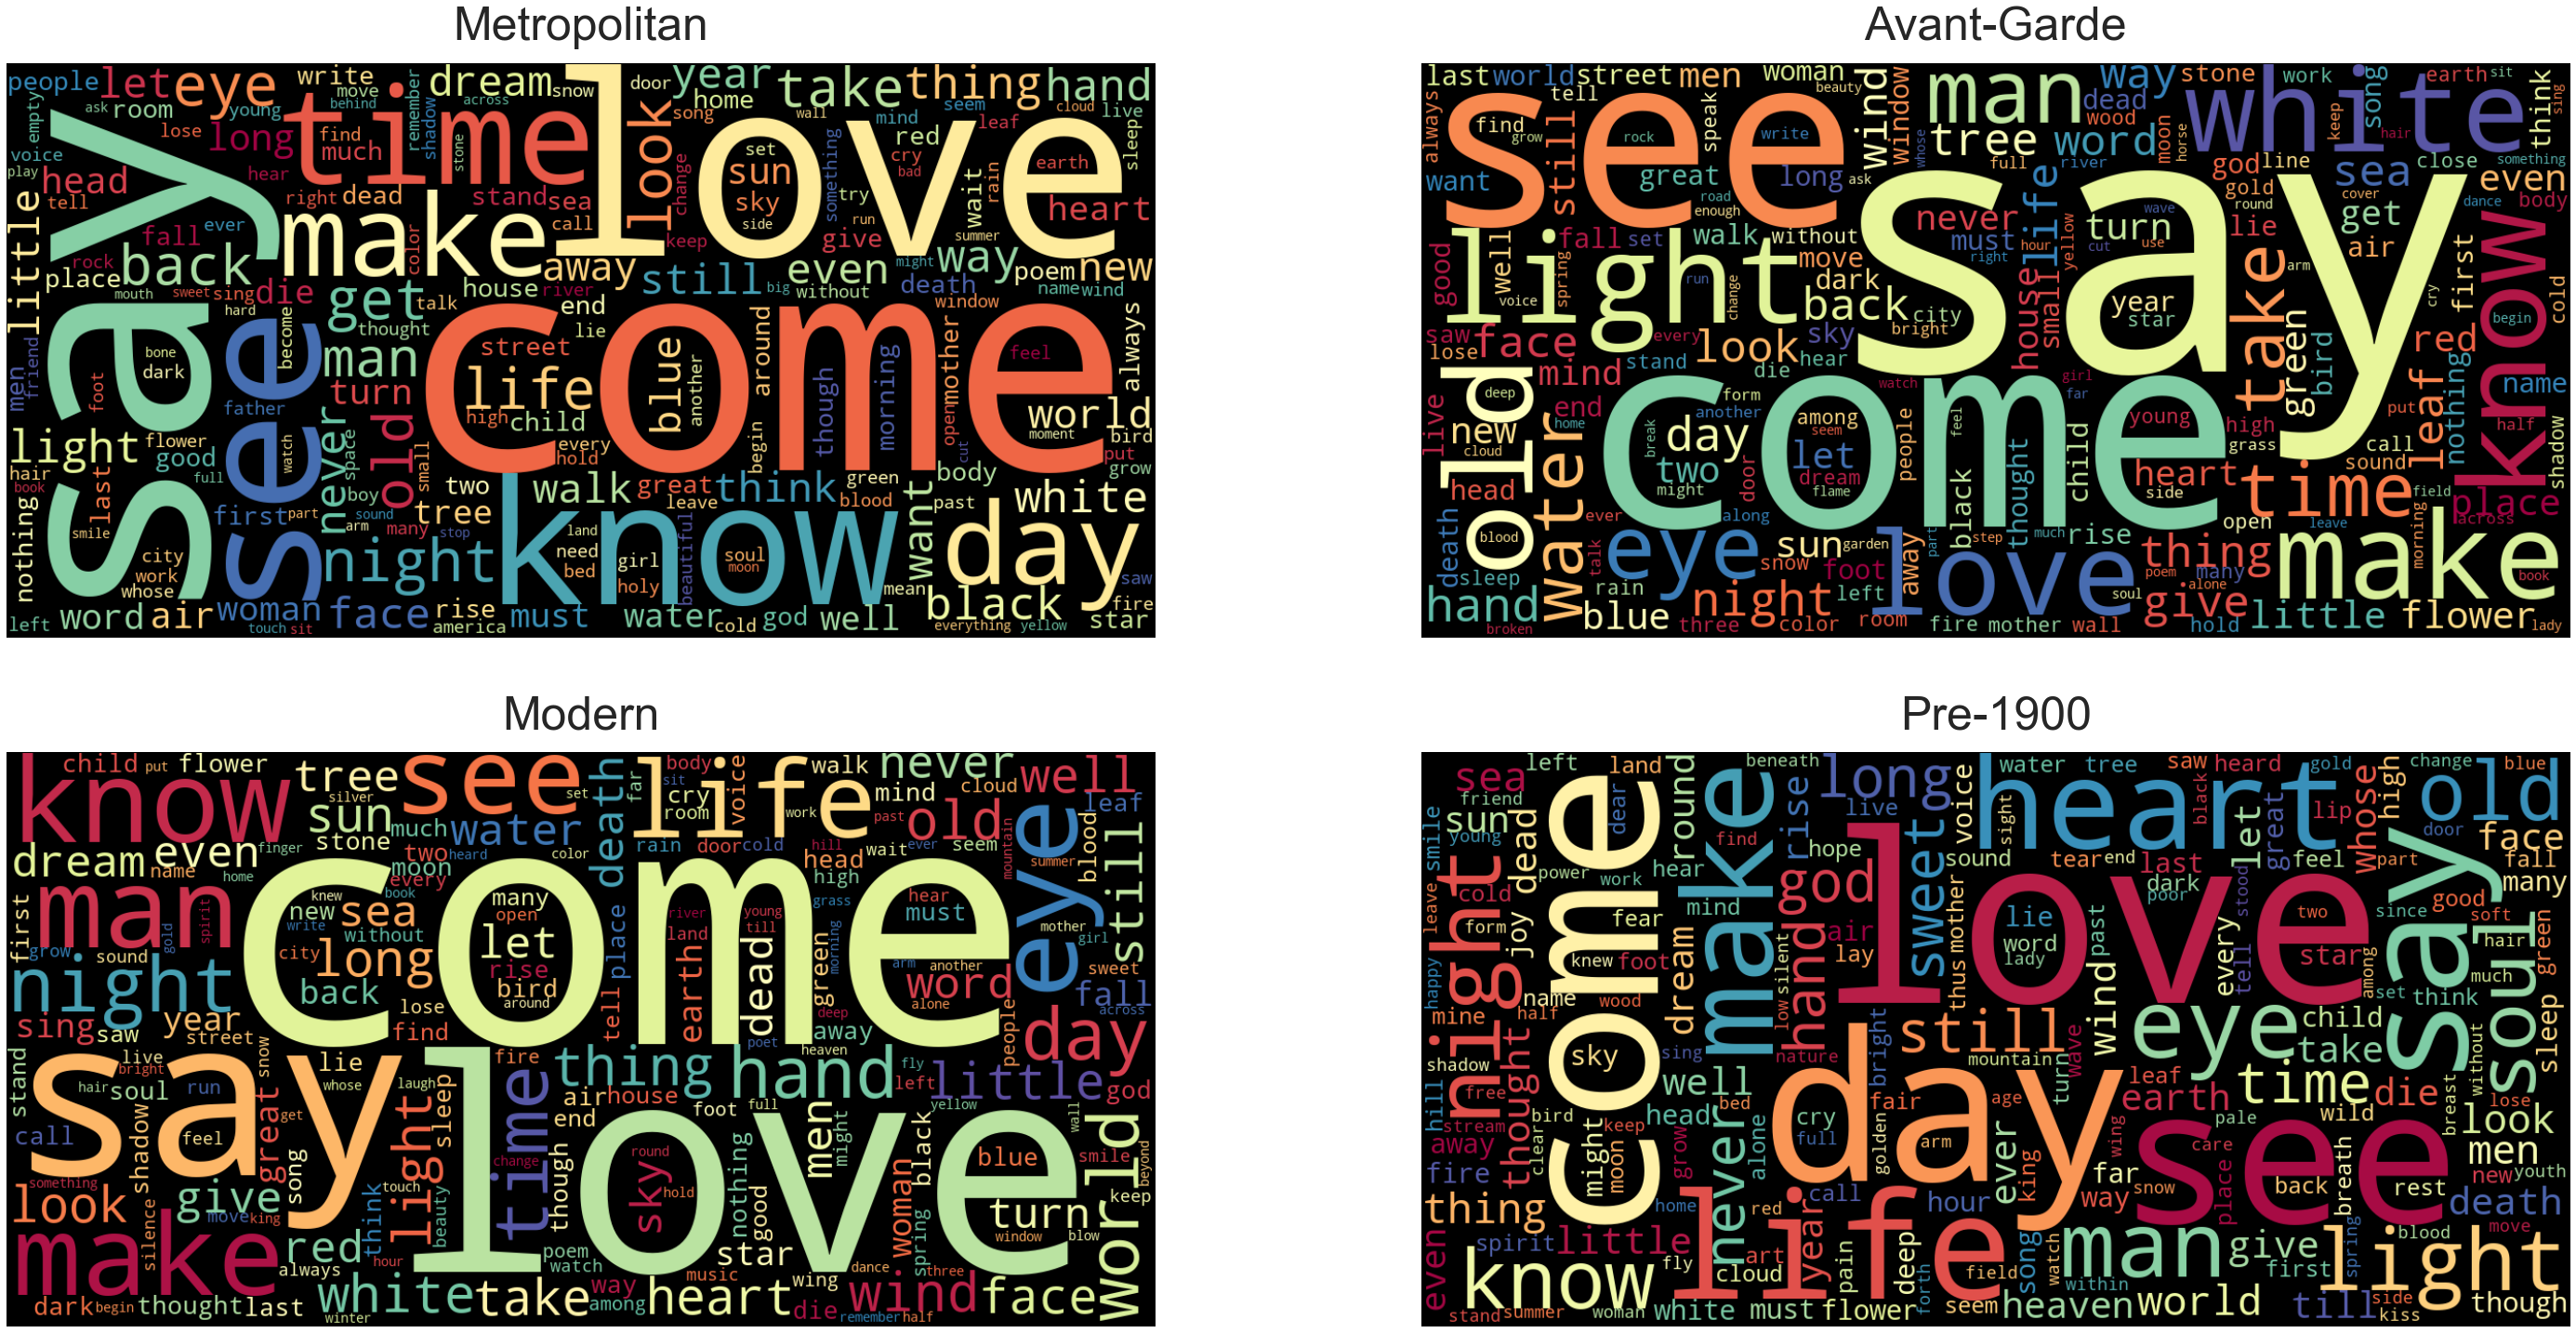

In [106]:
plt.figure(figsize=(50,25))

movements = list(df.movement.unique())

for i, movement in enumerate(movements):
    # create a series of processed poem strings
    movement_string_series = df[df.movement == movement].string_cleaned
    
    # convert the series to one big string
    movement_big_string = ' '.join(movement_string_series)
    
    # split the big string so I get all words in the movement
    movement_words = movement_big_string.split()
    
    # create a dictionary for easy word cloud creation
    movement_word_dict = dict(Counter(movement_words))

    # create word cloud
    movement_wordcloud = WordCloud(colormap='Spectral', width=1200, height=600).\
                                                        generate_from_frequencies(movement_word_dict)

    nrows = 2
    ncols = 2

    plt.subplot(nrows, ncols, i+1)
    plt.plot()
    plt.imshow(movement_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{movement.title().replace("_", "-")}', fontsize=50, pad=25)
              
# # uncomment to save
# plt.savefig('charts/word_cloud_movement.png', bbox_inches='tight', transparent=True)

# Preliminary conclusions

[[go back to the top](#Predicting-Poetic-Movements)]

- Pre-1900 poetry is easily recognized.
    - High number of end rhymes, most words per line, simpler words (fewer syllables per word), most positive, and most repetitious.
- Avant-garde is more or less the opposite.
    - Practically no end rhymes, fewest words per line, more complex words (more syllables per word), and richest use of language.
- Metropolitan and Modern poetries are often somewhere in between.
- Poetry is rarely neutral (and generally positive) and fairly equally subjective/objective.
- Frequent vocabulary includes visual and temporal language.

## 💾 Save/Load DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

In [107]:
# # uncomment to save
# with gzip.open('data/poetry_movements_df.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_movements_df.pkl', 'rb') as hello:
#     df = pickle.load(hello)

## Next notebook: [Modeling](04_modeling.ipynb)

[[go back to the top](#Predicting-Poetic-Movements)]

- The next notebook includes classification modeling, a section with reproducible code for this project (including the work within this notebook), conclusions, and acknowledgements.